In [64]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import eig

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow



In [65]:
def cholesky_with_jitter(K, jitter):
    k_diag = tf.linalg.diag_part(K)
    jitter_diag = tf.fill(tf.shape(k_diag), tf.cast(jitter, dtype=K.dtype))
    jittered_K = tf.linalg.set_diag(K, k_diag + jitter_diag)
    return tf.linalg.cholesky(jittered_K)

K1 = gpflow.kernels.SquaredExponential(variance=1, lengthscales=5)

pi = tf.cast(np.pi, tf.float64)

noise = tf.cast(1, tf.float64)

In [66]:
N = 100
M = 30

In [67]:
Xs = np.linspace(1, 10, 100).reshape(-1,1)
X = np.random.uniform(1, 10, N).reshape(-1,1)
Y = X

Z1 = X[0:M]

In [68]:
m1 = tf.Variable(np.linspace(1,10,M).reshape(-1,1))
S1 = tf.Variable(np.identity(M))

In [69]:
def elbo(m1,S1):
    
    likelihood_GP = 0
    inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))
    

    for i in range (0,N):
        f1_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),m1)
        f1_sample_covariance = K1(X[i].reshape(-1,1),X[i].reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),K1(Z1,X[i].reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,X[i].reshape(-1,1)))
        f1_sample = tf.math.reduce_mean(tfp.distributions.Normal(f1_sample_mean,f1_sample_covariance).sample(100))
        
        likelihood =tf.math.multiply(tf.cast(-1/2,tf.float64),tf.math.log(tf.math.multiply(tf.cast(2,tf.float64),tf.math.multiply(pi,tf.math.square(noise))))) - tf.math.divide(tf.math.square((Y[i]-f1_sample)),tf.math.square(noise))
        likelihood_GP = likelihood_GP + likelihood
      
   
    KL1 = tf.math.multiply(tf.cast(-1/2,tf.float64),(tf.linalg.trace(tf.linalg.matmul(inv_K_Z1Z1,S1@tf.transpose(S1)))+tf.linalg.matmul(tf.linalg.matmul(tf.transpose(m1),inv_K_Z1Z1),m1)-M+tf.math.log(tf.linalg.det(cholesky_with_jitter(K1(Z1,Z1),1e-5)))-tf.math.log(tf.linalg.det(S1@tf.transpose(S1)))))
   
    KL_GP = KL1
    
    elbo =  (likelihood_GP - KL_GP)



    return elbo

In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1)
for i in range(100):
    with tf.GradientTape() as tape:
        objective = elbo(m1,S1)
        gradients = tape.gradient(objective, [m1,S1])
    print(i, "objective:", objective)
    optimizer.apply_gradients(zip(gradients, [m1,S1]))

0 objective: tf.Tensor([[1.02194073e+12]], shape=(1, 1), dtype=float64)
1 objective: tf.Tensor([[2.49713195e+12]], shape=(1, 1), dtype=float64)
2 objective: tf.Tensor([[6.00685107e+11]], shape=(1, 1), dtype=float64)
3 objective: tf.Tensor([[8.06233542e+11]], shape=(1, 1), dtype=float64)
4 objective: tf.Tensor([[1.12614426e+12]], shape=(1, 1), dtype=float64)
5 objective: tf.Tensor([[8.51997827e+11]], shape=(1, 1), dtype=float64)
6 objective: tf.Tensor([[5.50368326e+11]], shape=(1, 1), dtype=float64)
7 objective: tf.Tensor([[5.14782709e+11]], shape=(1, 1), dtype=float64)
8 objective: tf.Tensor([[6.06757345e+11]], shape=(1, 1), dtype=float64)
9 objective: tf.Tensor([[5.83832107e+11]], shape=(1, 1), dtype=float64)
10 objective: tf.Tensor([[4.28161363e+11]], shape=(1, 1), dtype=float64)
11 objective: tf.Tensor([[2.87826695e+11]], shape=(1, 1), dtype=float64)
12 objective: tf.Tensor([[2.51272534e+11]], shape=(1, 1), dtype=float64)
13 objective: tf.Tensor([[2.84368352e+11]], shape=(1, 1), dty

In [71]:
inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))
f1_sample_mean = np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),m1)
f1_sample_covariance = K1(Xs,Xs)-np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),K1(Z1,Xs))+np.matmul(np.matmul(np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,Xs))
f1_samples = np.random.multivariate_normal(f1_sample_mean.reshape(100,), f1_sample_covariance, 10)



/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


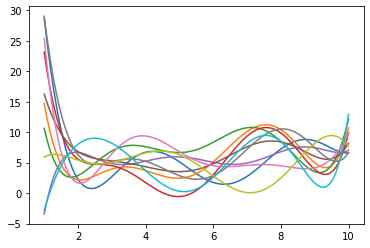

In [73]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f1_samples.T)